In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

#load data file         
data = pd.read_csv("/kaggle/input/blood-cells/dataset2-master/dataset2-master/labels.csv")

In [49]:
data

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
...,...,...,...
406,NaN,406,NaN
407,NaN,407,NEUTROPHIL
408,NaN,408,NEUTROPHIL
409,NaN,409,NEUTROPHIL


In [50]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

# load an image from file
image1 = load_img("/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_1173.jpeg", target_size=(168, 168))

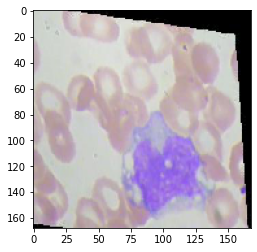

In [51]:
#print of the image, this is a monocyte
plt.imshow(image1)

In [52]:
# load an image from file
image2 = load_img("/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_2142.jpeg", target_size=(168, 168))

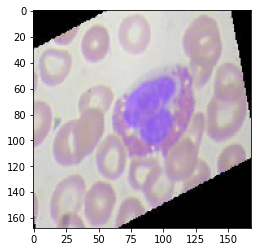

In [53]:
#this is a eosinophil
plt.imshow(image2)

In [54]:
image3 = load_img("/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg", target_size=(168, 168))

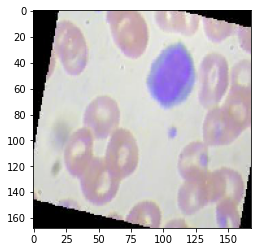

In [55]:
#lymphocyte
plt.imshow(image3)

In [56]:
image4 = load_img("/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_100_8981.jpeg", target_size=(168, 168))

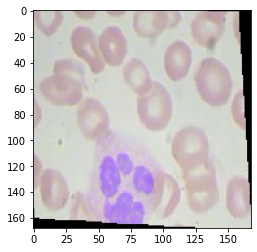

In [57]:
#neutrophil
plt.imshow(image4)

In [58]:
#count how many images for each type of cells 
data['Category'].value_counts()

NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
MONOCYTE, LYMPHOCYTE        1
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,EOSINOPHIL       1
EOSINOPHIL,EOSINOPHIL       1
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL, LYMPHOCYTE      1
EOSINOPHIL, LYMPHOCYTE      1
LYMPHOCYTE, LYMPHOCYTE      1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, MONOCYTE        1
Name: Category, dtype: int64

**Building my own model: **

In [59]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import GaussianNoise

In [60]:
#in order to improve validation accuracyadded drop outs, noise
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = (64, 64, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(GaussianNoise(0.1))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(4, activation='softmax'))
    
    adam = Adam(lr=0.00001)
    model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
    return model

model= create_model()

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 32)       

In [62]:
train_gen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                               samplewise_center=False,  # set each sample mean to 0
                               featurewise_std_normalization=False,  # divide inputs by std of the dataset
                               samplewise_std_normalization=False,  
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

In [63]:
train = train_gen.flow_from_directory('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'categorical')

test = test_gen.flow_from_directory('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST',
                                    target_size = (64, 64),
                                    batch_size = 16,
                                    class_mode = 'categorical')

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [64]:
model.fit_generator(train,
                    steps_per_epoch = 500,
                    epochs = 100,
                    validation_data = test,
                    validation_steps = 500, shuffle=True)

Epoch 1/100
500/500 [==============================] - 52s 104ms/step - loss: 1.1279 - accuracy: 0.4976 - val_loss: 0.9490 - val_accuracy: 0.6116
Epoch 2/100
500/500 [==============================] - 51s 102ms/step - loss: 0.6269 - accuracy: 0.7311 - val_loss: 8.7847 - val_accuracy: 0.2654
Epoch 3/100
500/500 [==============================] - 50s 99ms/step - loss: 0.4422 - accuracy: 0.8214 - val_loss: 3.7365 - val_accuracy: 0.4592
Epoch 4/100
500/500 [==============================] - 50s 99ms/step - loss: 0.3548 - accuracy: 0.8591 - val_loss: 5.0683 - val_accuracy: 0.3587
Epoch 5/100
500/500 [==============================] - 50s 99ms/step - loss: 0.2767 - accuracy: 0.8861 - val_loss: 13.7248 - val_accuracy: 0.3265
Epoch 6/100
500/500 [==============================] - 49s 99ms/step - loss: 0.2487 - accuracy: 0.8994 - val_loss: 1.1667 - val_accuracy: 0.6876
Epoch 7/100
500/500 [==============================] - 50s 99ms/step - loss: 0.2114 - accuracy: 0.9188 - val_loss: 4.1766 - val

Epoch 57/100
500/500 [==============================] - 50s 99ms/step - loss: 0.0383 - accuracy: 0.9870 - val_loss: 5.0970 - val_accuracy: 0.5669
Epoch 58/100
500/500 [==============================] - 51s 102ms/step - loss: 0.0266 - accuracy: 0.9914 - val_loss: 16.7259 - val_accuracy: 0.3341
Epoch 59/100
500/500 [==============================] - 49s 99ms/step - loss: 0.0408 - accuracy: 0.9859 - val_loss: 1.4677 - val_accuracy: 0.8070
Epoch 60/100
500/500 [==============================] - 49s 99ms/step - loss: 0.0365 - accuracy: 0.9864 - val_loss: 2.3336 - val_accuracy: 0.7318
Epoch 61/100
500/500 [==============================] - 49s 98ms/step - loss: 0.0442 - accuracy: 0.9854 - val_loss: 1.7262 - val_accuracy: 0.6956
Epoch 62/100
500/500 [==============================] - 49s 99ms/step - loss: 0.0474 - accuracy: 0.9846 - val_loss: 7.3422 - val_accuracy: 0.5046
Epoch 63/100
500/500 [==============================] - 49s 99ms/step - loss: 0.0382 - accuracy: 0.9886 - val_loss: 4.1301

> Transfer learning model:

In [79]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input

In [80]:
from keras.applications.vgg16 import VGG16

In [81]:
#load model
model = VGG16()

#summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [82]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense
from itertools import islice
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalMaxPool2D, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
# from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam

In [83]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(64, 64, 3))


for layer in model.layers:
  model.get_layer(layer.name).trainable = False

flat1 = GlobalMaxPool2D()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(128, activation='relu')(class1)

z = Dense(128, activation='relu')(class2)
output = Dense(4, activation='softmax')(z)
# define new model
model = Model(inputs=model.inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])

In [85]:
model.fit_generator(train,
                    steps_per_epoch = 500,
                    epochs = 30,
                    validation_data = test,
                    validation_steps = 200)

Epoch 1/30
500/500 [==============================] - 237s 474ms/step - loss: 1.2251 - accuracy: 0.4785 - val_loss: 1.2277 - val_accuracy: 0.3804
Epoch 2/30
500/500 [==============================] - 238s 476ms/step - loss: 1.1812 - accuracy: 0.5021 - val_loss: 1.1956 - val_accuracy: 0.3876
Epoch 3/30
500/500 [==============================] - 237s 475ms/step - loss: 1.1444 - accuracy: 0.5201 - val_loss: 1.1638 - val_accuracy: 0.4351
Epoch 4/30
500/500 [==============================] - 236s 473ms/step - loss: 1.1124 - accuracy: 0.5464 - val_loss: 1.1503 - val_accuracy: 0.4339
Epoch 5/30
500/500 [==============================] - 236s 473ms/step - loss: 1.0866 - accuracy: 0.5590 - val_loss: 1.1239 - val_accuracy: 0.4688
Epoch 6/30
500/500 [==============================] - 236s 472ms/step - loss: 1.0655 - accuracy: 0.5693 - val_loss: 1.1085 - val_accuracy: 0.4692
Epoch 7/30
500/500 [==============================] - 236s 471ms/step - loss: 1.0379 - accuracy: 0.5794 - val_loss: 1.0779 -